In [1]:
from datetime import datetime
import pandas as pd
from neuralprophet import NeuralProphet
import matplotlib as plt
from matplotlib import pyplot
import sys
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pandas import to_datetime
import warnings
warnings.filterwarnings("ignore")
#sys.path.insert(0, '/Users/koushikchennakesavan/Documents/EE364D/ml-covid-nba')
#may need to fix this with your FP to ml-covid-nba
from data.injury_labeller import injuryScore

In [97]:
scoreGen = injuryScore.injuryScore("embiijo01", 2019)
df = scoreGen.getInjuryScore()
df = df.dropna()
df = df[['Date', 'Injury and Fatigue Score']]

scoreGen = injuryScore.injuryScore("embiijo01", 2020)
df1 = scoreGen.getInjuryScore()
df1 = df1.dropna()
df1 = df1[['Date', 'Injury and Fatigue Score']]
df1 = df1[df1['Date'] < '2020-08-01']

scoreGen = injuryScore.injuryScore("embiijo01", 2021)
df2 = scoreGen.getInjuryScore()
df2 = df2.dropna()
df2 = df2[['Date', 'Injury and Fatigue Score']]

df = pd.concat([df, df1, df2])

In [98]:
scoreGen = injuryScore.injuryScore("embiijo01", 2022)
test = scoreGen.getInjuryScore()
test = test.dropna()
test = test[['Date', 'Injury and Fatigue Score']]
test.columns = ['ds', 'y']
df.loc[len(df)] = list(test.loc[0].values)

In [99]:
df.columns = ['ds', 'y']
games = df.pop('ds')
df.index = pd.to_datetime(games)
df = df.resample('D').interpolate()

In [101]:
games = pd.DataFrame({
    'event': 'games',
    'ds': games.values,
})

In [105]:
future_games = pd.DataFrame({
    'event': 'games',
    'ds': test.ds,
})

In [131]:
df['ds']= df.index
model = NeuralProphet(num_hidden_layers=1,
                      d_hidden=150,
                      n_forecasts=100,
                      n_lags=150,
                      changepoints_range=.9,
                      trend_reg=50,
                      seasonality_mode='multiplicative',
                      loss_func='MSE')
model.add_events(["games"])
history_df = model.create_df_with_events(df, games)
model.fit(history_df)
future_days = model.make_future_dataframe(df=history_df, events_df=pd.concat([games, future_games]), periods=100)
future_predict = model.predict(future_days)
future_predict = future_predict.fillna(method='bfill', axis=1)
#model.plot(future_predict, uncertainty=True)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 135


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.87E+00, min: 1.48E-01


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.88E+00, min: 1.06E-01


  0%|          | 0/246 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.88E+00, min: 1.06E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.16E+00
Epoch[135/135]: 100%|██████████| 135/135 [00:19<00:00,  6.93it/s, MSELoss=0.0276, MAE=0.0367, RMSE=0.0478, RegLoss=4.56e-6] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.6% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.6% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [132]:
future_predict = future_predict[['ds', 'y']]
future_predict = future_predict[future_predict['ds'].isin(test['ds'])]
#print(test)
#print(future_predict)
print(mean_squared_error(test['y'][:len(future_predict)], future_predict['y'], squared=True))
print(r2_score(test['y'][:len(future_predict)], future_predict['y']))
print(mean_absolute_error(test['y'][:len(future_predict)], future_predict['y']))

0.0017666569491188602
0.5394263373873377
0.03191206796749218


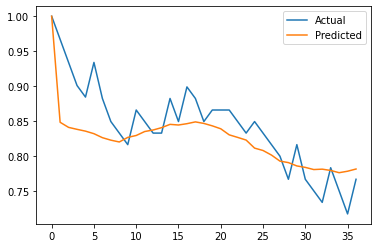

In [133]:
pyplot.plot(test['y'][:len(future_predict)].values, label='Actual')
pyplot.plot(future_predict['y'].values, label='Predicted')
pyplot.legend()
pyplot.show()